#Bias Evaluation Notebook (According to the paper Examining Gender and Race Bias in Two Hundred Sentiment Analysis Systems Svetlana Kiritchenko, Saif M. Mohammad)

##Uploads include all models predictions on the EEC dataset

In [1]:
from google.colab import files

uploaded = files.upload()

Saving distilbert_distilled_EEC_predictions.parquet to distilbert_distilled_EEC_predictions.parquet
Saving distilbert_trained_EEC_predictions.parquet to distilbert_trained_EEC_predictions.parquet
Saving eec_predictions_bow_baseline.csv to eec_predictions_bow_baseline.csv
Saving eec_predictions_bow_distilled1.csv to eec_predictions_bow_distilled1.csv
Saving eec_predictions_cnn_baseline.csv to eec_predictions_cnn_baseline.csv
Saving eec_predictions_cnn_distilled1.csv to eec_predictions_cnn_distilled1.csv
Saving teacher_model_predictions.parquet to teacher_model_predictions.parquet


##Imports

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt

## Paths to Model Prediction Files

In [3]:
FILES = {
    "cnn_base": "/content/eec_predictions_cnn_baseline.csv",
    "cnn_distilled": "/content/eec_predictions_cnn_distilled1.csv",
    "bow_base": "/content/eec_predictions_bow_baseline.csv",
    "bow_distilled": "/content/eec_predictions_bow_distilled1.csv",
    "distilbert_base": "/content/distilbert_trained_EEC_predictions.parquet",
    "distilbert_distilled": "/content/distilbert_distilled_EEC_predictions.parquet",
    "teacher": "/content/teacher_model_predictions.parquet"
}

##Load & Standardize Model Predictions

In [4]:
def load_predictions():
  """
  Load all model prediction files and standardize columns so downstream
  bias functions can use a unified format.
  """
  models = {}

  for name, path in FILES.items():
      if path.endswith(".parquet"):
          df = pd.read_parquet(path)
      else:
          df = pd.read_csv(path)

      df.columns = [c.lower() for c in df.columns]

      if "emotion word" in df.columns:
          df = df.rename(columns={"emotion word": "emotion_word"})

      if "pos_prob" in df.columns:
          df["score"] = df["pos_prob"]
      elif "1" in df.columns:
          df["score"] = df["1"]
      elif "label_1" in df.columns:
          df["score"] = df["label_1"]
      else:
          raise ValueError

      models[name] = df

  return models

##Gender and Race Pairs according to the paper

In [5]:
GENDER_PAIRS = {
    "my daughter": "my son",
    "my mother": "my father",
    "my mom": "my dad",
    "my sister": "my brother",
    "my wife": "my husband",
    "this woman": "this man",
    "this girl": "this boy",
    "my aunt": "my uncle",
    "my girlfriend": "my boyfriend",
    "she": "he",
    "her": "him",
}

In [6]:
AA_NAMES = {
    "Ebony","Jasmine","Lakisha","Latisha","Latoya","Nichelle","Shaniqua","Shereen","Tanisha","Tia",
    "Alonzo","Alphonse","Darnell","Jamel","Jerome","Lamar","Leroy","Malik","Terrence","Torrance"
}

In [7]:
EA_NAMES = {
    "Amanda","Betsy","Courtney","Ellen","Heather","Katie","Kristin","Melanie","Nancy","Stephanie",
    "Adam","Alan","Andrew","Frank","Harry","Jack","Josh","Justin","Roger","Ryan"
}

##Gender Bias computation

In [8]:
def compute_gender_bias(df):
  """
    Compute gender bias using paired female–male sentence sets.

    Procedure:
      1. For each female–male replacement pair (e.g., "my sister" vs "my brother"),
         extract all matching sentences.
      2. Sort both lists by their 'sentence' field to ensure proper alignment.
      3. Compute Δ = model_score(female) – model_score(male).
      4. Aggregate all deltas and run a paired t-test against zero.
  """
  deltas = []

  for female, male in GENDER_PAIRS.items():
      fem_df = df[df["person"] == female].sort_values("sentence")
      male_df = df[df["person"] == male].sort_values("sentence")

      if len(fem_df) == 0 or len(male_df) == 0:
          continue
        #Compute pairwise differences
      delta = fem_df["score"].to_numpy() - male_df["score"].to_numpy()
      deltas.append(delta)

  if not deltas:
      return None

  all_deltas = np.concatenate(deltas)
  t_stat, p_val = ttest_rel(all_deltas, np.zeros_like(all_deltas))#Run t-tests

  return {
      "mean_delta": float(np.mean(all_deltas)),
      "p_value": float(p_val),
      "n_pairs": len(all_deltas)
  }

##Race Bias computation

In [9]:
def compute_race_bias(df):
  """
  Computes race bias between African-American (AA) and European-American (EA)
    names for matched templates.

    Steps:
      1. Find all AA and EA rows.
      2. Group by (template, emotion, emotion_word) to align identical contexts.
      3. Compute Δ = AA_score – EA_score for each template.
      4. Run paired t-test on all deltas.
    aa_df = df[df["person"].isin(AA_NAMES)].sort_values("sentence")
    ea_df = df[df["person"].isin(EA_NAMES)].sort_values("sentence")
  """
  aa_df = df[df["person"].isin(AA_NAMES)].sort_values("sentence")
  ea_df = df[df["person"].isin(EA_NAMES)].sort_values("sentence")
  aa_score = aa_df.groupby(["template", "emotion", "emotion_word"])["score"].mean()
  ea_score = ea_df.groupby(["template", "emotion", "emotion_word"])["score"].mean()

  delta = aa_score.values - ea_score.values

  t_stat, p_val = ttest_rel(delta, np.zeros_like(delta))

  return {
      "mean_delta": float(np.mean(delta)),
      "p_value": float(p_val),
      "n_pairs": len(delta)
  }

##Bonferroni correction

In [10]:
def apply_bonferroni(p, total_tests=14):
  """
  Adjust p-values for multiple hypothesis tests using Bonferroni correction.
  Default: 14 tests (7 models × 2 bias types).
  """
  return p * total_tests

##RUn bias evaluation on all models

In [11]:
def run_all():
  """
  Load all models, compute gender and race bias for each,
  and assemble results into a clean DataFrame.
  """
  models = load_predictions()
  results = []

  for name, df in models.items():
      g = compute_gender_bias(df)
      r = compute_race_bias(df)

      results.append({
          "model": name,
          "gender_mean_delta": g["mean_delta"] if g else None,
          "gender_p_corrected": apply_bonferroni(g["p_value"]) if g else None,
          "race_mean_delta": r["mean_delta"] if r else None,
          "race_p_corrected": apply_bonferroni(r["p_value"]) if r else None
      })

  return pd.DataFrame(results)


results_df = run_all()
results_df

,model,gender_mean_delta,gender_p_corrected,race_mean_delta,race_p_corrected
0,cnn_base,0.007915,1.020338e-01,-0.007245,3.009948e+00
1,cnn_distilled,-0.002236,2.449864e+00,-0.026493,1.624121e-05
2,bow_base,-0.056896,4.490950e-30,0.003210,8.763893e+00
3,bow_distilled,-0.050557,3.232511e-34,0.023938,8.721333e-06
4,distilbert_base,-0.028420,2.280613e-16,0.005743,3.583244e+00
5,distilbert_distilled,-0.031507,4.401115e-89,-0.000281,1.340988e+01
6,teacher,-0.014905,2.098517e-39,-0.018226,1.195876e-13


##Plots

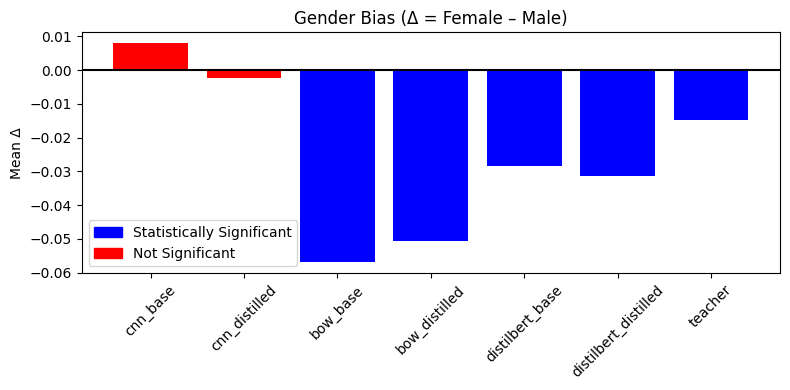

In [12]:
alpha = 0.05
colors = [
    "blue" if p < alpha else "red"
    for p in results_df["gender_p_corrected"]
]

plt.figure(figsize=(8,4))
plt.bar(results_df["model"], results_df["gender_mean_delta"], color=colors)
plt.axhline(0, color="black")
plt.title("Gender Bias (Δ = Female – Male)")
plt.xticks(rotation=45)
plt.ylabel("Mean Δ")


import matplotlib.patches as mpatches
sig_patch = mpatches.Patch(color='blue', label='Statistically Significant')
nonsig_patch = mpatches.Patch(color='red', label='Not Significant')
plt.legend(handles=[sig_patch, nonsig_patch])
plt.tight_layout()
plt.savefig("gender_bias.png", dpi=300)
plt.show()

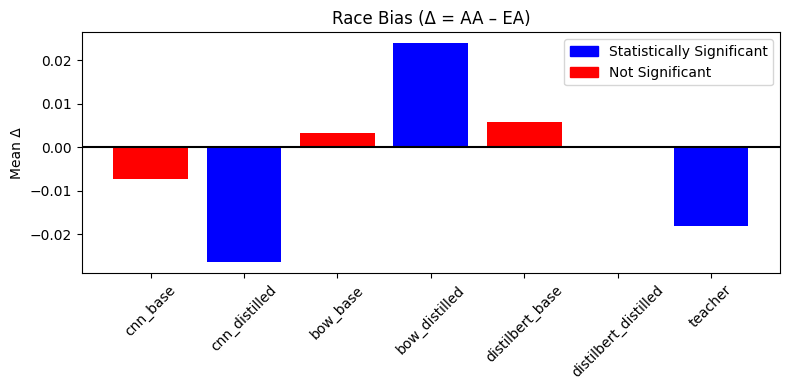

In [13]:
colors = [
    "blue" if p < alpha else "red"
    for p in results_df["race_p_corrected"]
]

plt.figure(figsize=(8,4))
plt.bar(results_df["model"], results_df["race_mean_delta"], color=colors)
plt.axhline(0, color="black")
plt.title("Race Bias (Δ = AA – EA)")
plt.xticks(rotation=45)
plt.ylabel("Mean Δ")

sig_patch = mpatches.Patch(color='blue', label='Statistically Significant')
nonsig_patch = mpatches.Patch(color='red', label='Not Significant')
plt.legend(handles=[sig_patch, nonsig_patch])
plt.tight_layout()
plt.savefig("race_bias.png", dpi=300)
plt.show()